In [23]:
import pandas as pd
import xarray as xr
import numpy as np
import scipy.interpolate
from netCDF4 import Dataset
import bottleneck
import pyarrow
import scipy.ndimage as ndimage
import geopandas

import matplotlib.pyplot as plt

# Reading in the Data

In [24]:
# Import Merged Data from Notebook in Cloud
data = pd.read_parquet('../../finalproj_data/ds_df.parquet', engine = 'pyarrow')

In [25]:
data.shape

(1034376, 50)

In [26]:
data.head()

,lat,lon,firemask,MaxFRP,gaugeQualityInfo,hourlyPrecipRate,hourlyPrecipRateGC,observationTimeFlag,satelliteInfoFlag,Albedo_inst,...,Swnet_tavg,Tair_f_inst,Tveg_tavg,Wind_f_inst,BurnDate,Uncertainty,QA,FirstDay,LastDay,FWI
0,-4.98565,106.360530,3.0,NaN,0.0,0.0,0.415,-1.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
1,-4.98565,106.405485,3.0,NaN,0.0,0.0,0.415,-1.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
2,-4.98565,106.450441,3.0,NaN,0.0,0.0,0.415,-1.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
3,-4.98565,106.495396,3.0,NaN,0.0,0.0,0.415,-1.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
4,-4.98565,106.540352,3.0,NaN,0.0,0.0,0.415,-1.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN


In [27]:
data.columns

Index(['lat', 'lon', 'firemask', 'MaxFRP', 'gaugeQualityInfo',
       'hourlyPrecipRate', 'hourlyPrecipRateGC', 'observationTimeFlag',
       'satelliteInfoFlag', 'Albedo_inst', 'AvgSurfT_inst', 'CanopInt_inst',
       'ECanop_tavg', 'ESoil_tavg', 'Evap_tavg', 'LWdown_f_tavg', 'Lwnet_tavg',
       'PotEvap_tavg', 'Psurf_f_inst', 'Qair_f_inst', 'Qg_tavg', 'Qh_tavg',
       'Qle_tavg', 'Qs_acc', 'Qsb_acc', 'Qsm_acc', 'Rainf_f_tavg',
       'RootMoist_inst', 'SWE_inst', 'SWdown_f_tavg', 'SnowDepth_inst',
       'Snowf_tavg', 'SoilMoi100_200cm_inst', 'SoilMoi10_40cm_inst',
       'SoilMoi40_100cm_inst', 'SoilTMP0_10cm_inst', 'SoilMoi0_10cm_inst',
       'SoilTMP100_200cm_inst', 'SoilTMP10_40cm_inst', 'SoilTMP40_100cm_inst',
       'Swnet_tavg', 'Tair_f_inst', 'Tveg_tavg', 'Wind_f_inst', 'BurnDate',
       'Uncertainty', 'QA', 'FirstDay', 'LastDay', 'FWI'],
      dtype='object')

In [28]:
# Drop columns that were not deemed important features
less_than_onepercent = [
 'gaugeQualityInfo',
 'observationTimeFlag',
 'satelliteInfoFlag',
 'ECanop_tavg',
 'Qg_tavg',
 'Qh_tavg',
 'Qs_acc',
 'Qsm_acc',
 'SWE_inst',
 'SWdown_f_tavg',
 'SnowDepth_inst',
 'Snowf_tavg',
 'SoilMoi40_100cm_inst',
 'SoilTMP10_40cm_inst',
 'Tveg_tavg',
 'Uncertainty']

data.drop(less_than_onepercent, axis = 1, inplace = True)

# Exploring the Data

In [31]:
d = data.astype('float')

In [32]:
d['firemask'].value_counts()

3.0    360887
5.0    339477
4.0     87932
9.0        81
8.0        57
6.0        19
7.0        16
Name: firemask, dtype: int64

In [33]:
# d.info()

In [34]:
# MAJOR ASSUMPTION: Fill all nulls with 0
d.fillna(0, inplace = True)

# Create Target Categories

In [69]:
# Start with all the values in FireMask
d['label'] = d['firemask']

In [70]:
d['label'].value_counts()

3.0    360887
5.0    339477
0.0    245907
4.0     87932
9.0        81
8.0        57
6.0        19
7.0        16
Name: label, dtype: int64

In [71]:
# Create categorical values for active fire pixels
# FireMask
# 3 = water, non-fire
# 4 = cloud (land or water)
# 5 = land, non-fire
# 6 = unknown (land or water)
# 7, 8, 9 = fire (low, nominal and high confidence)

d.loc[d['firemask'] == 3, 'label'] = 'water'
d.loc[d['firemask'] == 5, 'label'] = 'land'
d.loc[(d['firemask'] == 9) | (d['firemask'] == 8) | (data['firemask'] == 7), 'label'] = 'active_fire'

# 4, 6, and zero are unknown right now - we will fill those in later. 
d.loc[d['firemask'] == 0, 'label'] = 'unknown'
d.loc[d['firemask'] == 4, 'label'] = 'unknown'
d.loc[d['firemask'] == 6, 'label'] = 'unknown'

In [72]:
# If last day of burn is earlier than December 21 (day 344), mark as burned
d.loc[(d['LastDay'] < 344) & (d['LastDay'] > 0), 'label'] = 'burned'

# If last day of burn is day 344 - 345, mark as active fire
d.loc[((d['LastDay'] >= 344) & (d['LastDay'] <= 345)), 'label'] = 'active_fire'

# If last day of burn is after day 346, mark as land
# we will later delete these burned columns, so they will not distort the time dimension of the dataset
d.loc[(d['LastDay'] > 345), 'label'] = 'land'

In [75]:
# Using the other datasets, let's determine whether unknown pixels are land or water

# if the pixel has a starting burn date, we know it is land
d.loc[((d['label']=='unknown') & (d['FirstDay'] > 0)), 'label'] = 'land'

# If there is a FWI value for the pixel, it is land
d.loc[(d['label']=='unknown') & (d['FWI'] >0), 'label'] = 'land'

#If there is no (zero) FWI value, it is water
d.loc[(d['label']=='unknown') & (d['FWI'] == 0), 'label'] = 'water'

In [76]:
d['label'].value_counts()

water          636539
land           387857
burned           7481
active_fire      2499
Name: label, dtype: int64

In [77]:
# For "land" areas, create consolidated categories from FWI numerical
# based on the ranges appropriate for Australia
# consolidated 'very high' and 'extreme' categories

d.loc[(d['FWI'] >= 5) & (d['FWI'] < 8) & (d['label'] == 'land'), 'label'] = 'fwi_moderate'
d.loc[(d['FWI'] >= 8) & (d['FWI'] < 16) & (d['label'] == 'land'), 'label'] = 'fwi_high'
d.loc[(d['FWI'] >= 16) & (d['label'] == 'land'), 'label'] = 'fwi_extreme'

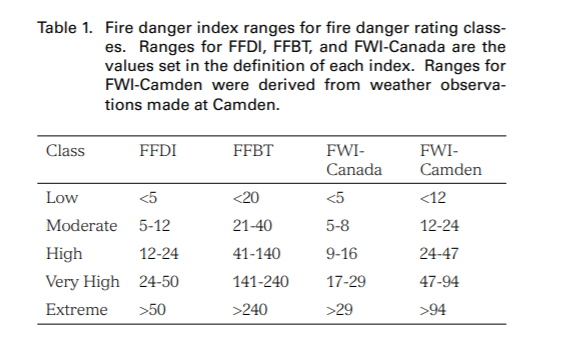

In [78]:
d['label'].value_counts()

water           636539
land            312957
fwi_extreme      52282
fwi_high         14954
fwi_moderate      7664
burned            7481
active_fire       2499
Name: label, dtype: int64

# Drop columns that were used to create labels

In [80]:
d.columns

Index(['lat', 'lon', 'firemask', 'MaxFRP', 'hourlyPrecipRate',
       'hourlyPrecipRateGC', 'Albedo_inst', 'AvgSurfT_inst', 'CanopInt_inst',
       'ESoil_tavg', 'Evap_tavg', 'LWdown_f_tavg', 'Lwnet_tavg',
       'PotEvap_tavg', 'Psurf_f_inst', 'Qair_f_inst', 'Qle_tavg', 'Qsb_acc',
       'Rainf_f_tavg', 'RootMoist_inst', 'SoilMoi100_200cm_inst',
       'SoilMoi10_40cm_inst', 'SoilTMP0_10cm_inst', 'SoilMoi0_10cm_inst',
       'SoilTMP100_200cm_inst', 'SoilTMP40_100cm_inst', 'Swnet_tavg',
       'Tair_f_inst', 'Wind_f_inst', 'BurnDate', 'QA', 'FirstDay', 'LastDay',
       'FWI', 'geometry', 'label'],
      dtype='object')

In [81]:
# Drop all variables that were used to create the label columns. 
data_v3 = d.drop(['firemask', 'MaxFRP','BurnDate', 'FirstDay', 'LastDay', 'FWI'], axis = 1)

In [82]:
# Export data as clean parquet gzip file
data_v3.to_parquet('../../finalproj_data/input_data/data_v3.parquet')

ArrowTypeError: ('Did not pass numpy.dtype object', 'Conversion failed for column geometry with type geometry')

In [36]:
data_v3['label'].value_counts()

fwi_low         582175
water           383783
fwi_extreme      30481
fwi_high         14398
fwi_veryhigh     13382
fwi_moderate      7733
burned            2231
active_fire        193
Name: label, dtype: int64